In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from rbf_neural_networks import RBFExperiment, RBFNeuralNetwork
from sklearn.model_selection import StratifiedKFold

In [2]:
def cross_validate_rbf(X, y, num_centers, n_splits=5):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=42
    )

    accs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = RBFNeuralNetwork(
            num_centers=num_centers,
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        acc = np.mean(y_pred == y_val)
        accs.append(acc)

    return np.mean(accs), np.std(accs)


K_list = [5, 10, 15, 20, 30, 40]


# 1 - IRIS Dataset

In [3]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
best_k_iris = None
best_score_iris = -np.inf

results = {}

for K in K_list:
    mean_acc, std_acc = cross_validate_rbf(
        X_train, y_train,
        num_centers=K
    )
    results[K] = (mean_acc, std_acc)
    print(f"K = {K} | CV Accuracy = {mean_acc:.4f} ± {std_acc:.4f}")

    if mean_acc > best_score_iris:
        best_score_iris = mean_acc
        best_k_iris = K

print(f"Best K = {best_k_iris} with CV accuracy = {best_score_iris:.4f}")

K = 5 | CV Accuracy = 0.8917 ± 0.0565
K = 10 | CV Accuracy = 0.8917 ± 0.0565
K = 15 | CV Accuracy = 0.8750 ± 0.0527
K = 20 | CV Accuracy = 0.9000 ± 0.0565
K = 30 | CV Accuracy = 0.8917 ± 0.0500
K = 40 | CV Accuracy = 0.9167 ± 0.0373
Best K = 40 with CV accuracy = 0.9167


In [5]:
experiment_iris = RBFExperiment(
    data_name="Base d'IRIS",
    num_centers=best_k_iris,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    learning_rate=0.01,
    epochs=100
)

In [6]:
experiment_iris.train()
experiment_iris.predict()

In [7]:
overall_acc_iris, class_acc_iris = experiment_iris.test_accuracy()

print(f"Test Accuracy: {overall_acc_iris * 100:.2f}%")
for c, acc in class_acc_iris.items():
    print(f"Accuracy class {c}: {acc * 100:.2f}%")

Test Accuracy: 100.00%
Accuracy class 0: 100.00%
Accuracy class 1: 100.00%
Accuracy class 2: 100.00%


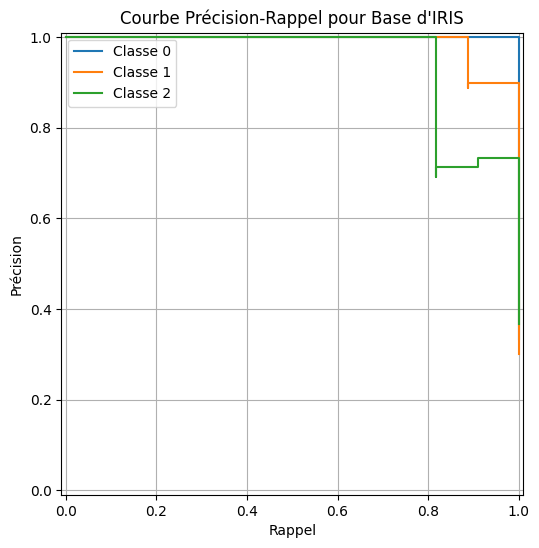

In [8]:
experiment_iris.plot_precision_recall_multiclass()

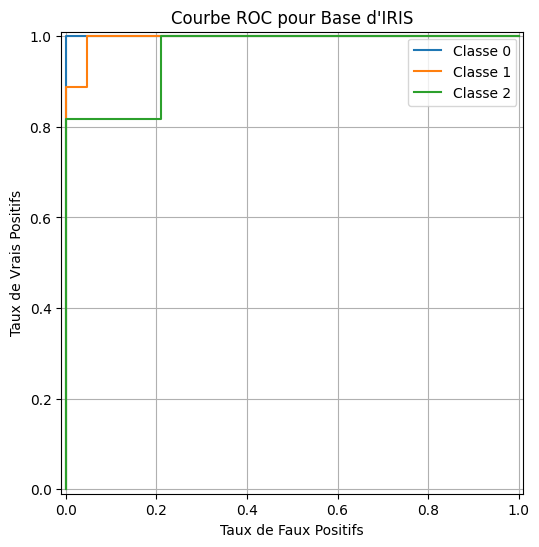

In [9]:
experiment_iris.plot_roc_multiclass()

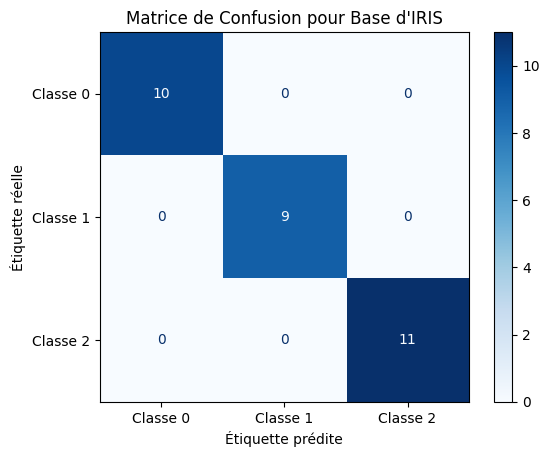

In [10]:
experiment_iris.plot_confusion_matrix()

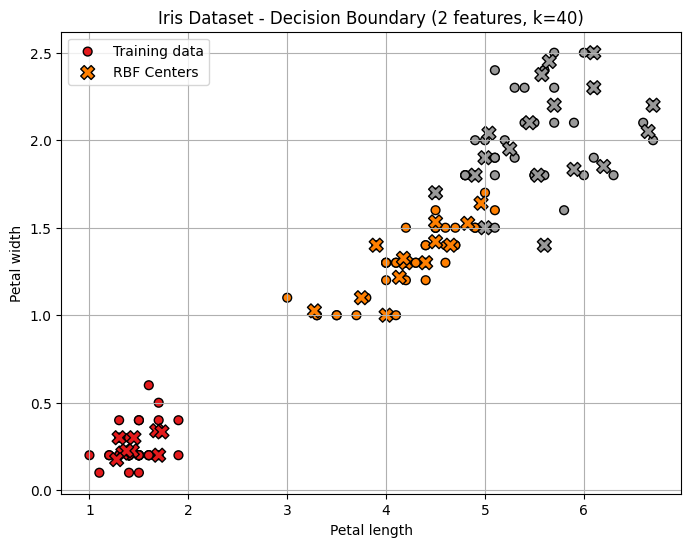

In [11]:
X_train_2d = X_train[:, 2:4]  # petal length, petal width
y_train_2d = y_train


from scipy.spatial.distance import cdist

centers = experiment_iris.model.centers[:, 2:4]  
distances = cdist(centers, X_train_2d)
nearest_idx = np.argmin(distances, axis=1)
centers_labels = y_train_2d[nearest_idx]

plt.figure(figsize=(8, 6))


plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_2d, cmap=plt.cm.Set1,
            edgecolor="k", s=40, label="Training data")
plt.scatter(centers[:, 0], centers[:, 1],
            c=centers_labels, cmap=plt.cm.Set1,
            s=100, marker="X", edgecolor="k", label="RBF Centers")

plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title(f"Iris Dataset - Decision Boundary (2 features, k={best_k_iris})")
plt.legend()
plt.grid(True)
plt.show()


# 2 - Wine Dataset

In [12]:
file_name = "Wine dataset.csv"

data = np.loadtxt(file_name, delimiter=",", skiprows=1)
X_wine = data[:, 1:] 
y_wine = data[:, 0].astype(int) - 1  

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=42
)

In [13]:
best_k_wine = None
best_score_wine = -np.inf

results = {}

for K in K_list:
    mean_acc_wine, std_acc_wine = cross_validate_rbf(
        X_train_wine, y_train_wine,
        num_centers=K
    )
    results[K] = (mean_acc_wine, std_acc_wine)
    print(f"K = {K} | CV Accuracy = {mean_acc_wine:.4f} ± {std_acc_wine:.4f}")

    if mean_acc_wine > best_score_wine:
        best_score_wine = mean_acc_wine
        best_k_wine = K

print(f"Best K = {best_k_wine} with CV accuracy = {best_score_wine:.4f}")

K = 5 | CV Accuracy = 0.6475 ± 0.0415
K = 10 | CV Accuracy = 0.6690 ± 0.0534
K = 15 | CV Accuracy = 0.6830 ± 0.0319
K = 20 | CV Accuracy = 0.6897 ± 0.0310
K = 30 | CV Accuracy = 0.6823 ± 0.0495
K = 40 | CV Accuracy = 0.6823 ± 0.0544
Best K = 20 with CV accuracy = 0.6897


In [14]:
experiment_wine = RBFExperiment(
    data_name="Base de VIN",
    num_centers=best_k_wine,
    X_train=X_train_wine,
    y_train=y_train_wine,
    X_test=X_test_wine,
    y_test=y_test_wine,
    learning_rate=0.01,
    epochs=100
)

In [15]:
experiment_wine.train()
experiment_wine.predict()

In [16]:
overall_train_acc_wine, class_train_acc_wine = experiment_wine.train_accuracy()

print(f"Train Accuracy: {overall_train_acc_wine * 100:.2f}%")
for c, acc in class_train_acc_wine.items():
    print(f"Train Accuracy class {c}: {acc * 100:.2f}%")

Train Accuracy: 69.01%
Train Accuracy class 0: 86.67%
Train Accuracy class 1: 75.44%
Train Accuracy class 2: 40.00%


In [17]:
overall_test_acc_wine, class_test_acc_wine = experiment_wine.test_accuracy()

print(f"Test Accuracy: {overall_test_acc_wine * 100:.2f}%")
for c, acc in class_test_acc_wine.items():
    print(f"Test Accuracy class {c}: {acc * 100:.2f}%")

Test Accuracy: 75.00%
Test Accuracy class 0: 100.00%
Test Accuracy class 1: 71.43%
Test Accuracy class 2: 37.50%


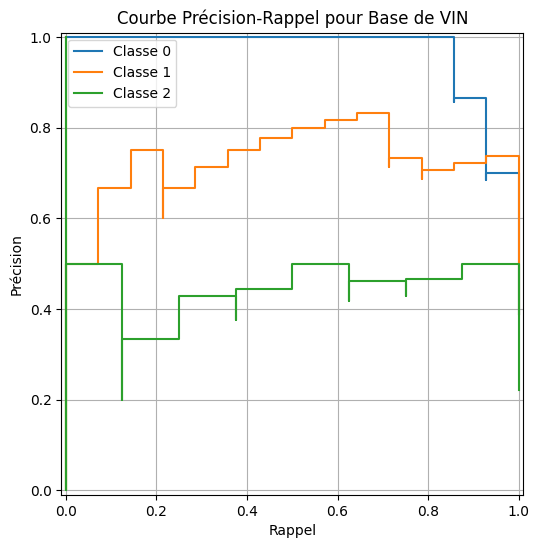

In [18]:
experiment_wine.plot_precision_recall_multiclass()

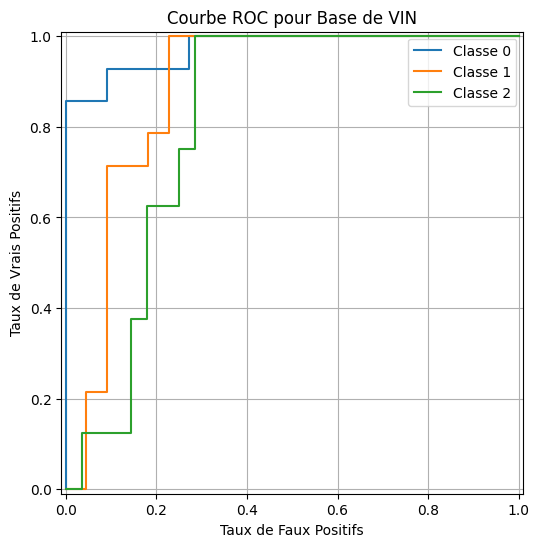

In [19]:
experiment_wine.plot_roc_multiclass()

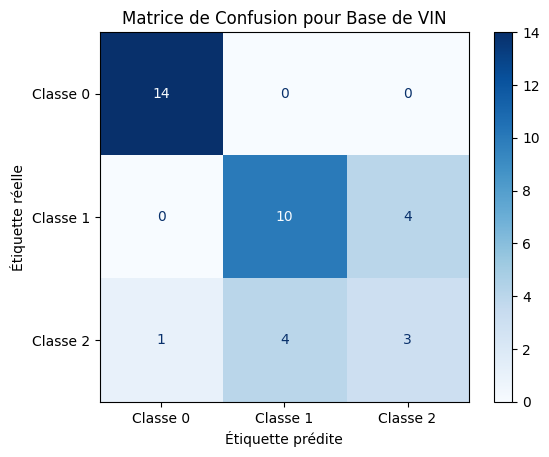

In [20]:
experiment_wine.plot_confusion_matrix()